<a href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.95.83.234:8470
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2204676422108459207),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11313756108960186354),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17654255306167292778),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14351922719313144005),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4973633010266650051),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0

In [1]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub 
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 283.40 KiB | 3.94 MiB/s, done.
Resolving deltas: 100% (185/185), done.



In [0]:
TASK = 'WikiQAv5.0'
BUCKET = 'bert-logs-zalo'
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
BERT_MODEL = 'multi_cased_L-12_H-768_A-12' 
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

***** Model output directory: gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0 *****


In [0]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)
tokenizer.tokenize('Học máy ( tiếng Anh : " machine learning " ) là một lĩnh vực của trí tuệ nhân tạo')

## Data

In [0]:
from tensorflow import keras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
def download(link, name):
  dataset = tf.keras.utils.get_file(
      fname=name+".zip", 
      origin=link, 
      extract=True)
  with tf.gfile.GFile(os.path.join(os.path.dirname(dataset), name+'.json'), "r") as f:
    data_dict = json.load(f)
    return data_dict

In [0]:
train_dict = download('https://dl.challenge.zalo.ai/ZAC2019_VietnameseWikiQA/train.zip','train')

2506752/2504567 [==============================] - 1s 0us/step


In [0]:
df = pd.DataFrame.from_dict(train_dict)

In [0]:
df['label']=np.where(df['label']==True,1,0)

In [0]:
train, dev = train_test_split(df, test_size=0.4,random_state=42)

In [0]:
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = x['label']), axis = 1)
dev_InputExamples = dev.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = x['label']), axis = 1)


In [0]:
label_list = [0, 1]

Also we initilize our hyperprams, prepare the training data and initialize TPU config.

In [0]:
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 256
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 1000

# Compute number of train and warmup steps from batch size
num_train_steps = int(len(train) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


# Fine-tune and Run Predictions on a pretrained BERT Model from TF Hub

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [0]:
def create_model(is_training, input_ids, input_mask, segment_ids, labels,
                 num_labels, bert_hub_module_handle):
  """Creates a classification model."""
  tags = set()
  if is_training:
    tags.add("train")
  bert_module = hub.Module(bert_hub_module_handle, tags=tags, trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # In the demo, we are doing a simple classification task on the entire
  # segment.
  #
  # If you want to use the token-level output, use
  # bert_outputs["sequence_output"] instead.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    if is_training:
      # I.e., 0.1 dropout
      output_layer = tf.nn.dropout(output_layer, keep_prob=0.5)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)

    return (loss, per_example_loss, logits, probabilities)

def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps, use_tpu, bert_hub_module_handle):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = create_model(
        is_training, input_ids, input_mask, segment_ids, label_ids, num_labels,
        bert_hub_module_handle)

    output_spec = None

    if mode == tf.estimator.ModeKeys.TRAIN:

      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits):
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(label_ids, predictions)
        loss = tf.metrics.mean(per_example_loss)
        f1_score = tf.contrib.metrics.f1_score(label_ids, predictions)
        return {
            "eval_accuracy": accuracy,
            "eval_loss": loss,
            "f1_score": f1_score
        }

      eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics)
    elif mode == tf.estimator.ModeKeys.PREDICT:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode, predictions={"probabilities": probabilities})
    else:
      raise ValueError(
          "Only TRAIN, EVAL and PREDICT modes are supported: %s" % (mode))

    return output_spec

  return model_fn


In [0]:
# Force TF Hub writes to the GS bucket we provide.
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.95.83.234:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7536fce5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.95.83.234:8470', '_evaluation_master': 'grpc://10.95.83.234:8470', '_is_chief': True, 

INFO:tensorflow:Using config: {'_model_dir': 'gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.95.83.234:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7536fce5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.95.83.234:8470', '_evaluation_master': 'grpc://10.95.83.234:8470', '_is_chief': True, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


At this point, you can now fine-tune the model, evaluate it, and run predictions on it.

In [0]:
# Train the model
def model_train(estimator):
  # We'll set sequences to be at most 128 tokens long.
  train_features = run_classifier.convert_examples_to_features(
      train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



In [0]:
model_train(estimator_from_tfhub)

In [0]:
def model_eval(estimator):
  # Eval the model.
  eval_features = run_classifier.convert_examples_to_features(
      dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(dev)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(dev) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))


In [0]:
model_eval(estimator_from_tfhub)

In [0]:
def model_predict(estimator, prediction_examples):
  eval_features = run_classifier.convert_examples_to_features(
      prediction_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=eval_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  predictions = estimator.predict(predict_input_fn)
  pred_dict = {}
  pred_dict["question"] = [] 
  pred_dict["text"] = [] 
  pred_dict["label"] = [] 
  pred_dict["pred"] = []
  for example, prediction in zip(prediction_examples, predictions):
    pred_dict["question"].append(example.text_a)
    pred_dict["text"].append(example.text_b)
    pred_dict["label"].append(example.label)
    pred_dict["pred"].append(np.squeeze(np.argmax(prediction['probabilities'], axis=-1)))
  #   print('text_a: %s\ntext_b: %s\nlabel:%s\nprediction:%s\n' % (example.text_a, example.text_b, str(example.label), prediction['labels']))
  df = pd.DataFrame.from_dict(pred_dict)
  return df

In [0]:
df_pred = model_predict(estimator_from_tfhub, dev_InputExamples)

In [0]:
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
print('***F1 SCORE DEV***')
print(f1_score(df_pred['label'],df_pred['pred']))
print('***REPORT DEV***')
print(classification_report(df_pred['label'],df_pred['pred']))
print('***CONFUSION MATRIX***')
print(confusion_matrix(df_pred['label'],df_pred['pred']))

***F1 SCORE DEV***
0.7999999999999999
***REPORT DEV***
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       126
           1       0.81      0.79      0.80        56

    accuracy                           0.88       182
   macro avg       0.86      0.85      0.86       182
weighted avg       0.88      0.88      0.88       182

***CONFUSION MATRIX***
[[116  10]
 [ 12  44]]


In [0]:
df_pred_train = model_predict(estimator_from_tfhub, train_InputExamples)

In [0]:
print('***ACCURACY TRAIN***')
print(accuracy_score(df_pred_train['label'],df_pred_train['pred']))
print('***F1 SCORE TRAIN***')
print(f1_score(df_pred_train['label'],df_pred_train['pred']))
print('***REPORT TRAIN***')
print(classification_report(df_pred_train['label'],df_pred_train['pred']))

***ACCURACY TRAIN***
0.9818141247350217
***F1 SCORE TRAIN***
0.971528384279476
***REPORT TRAIN***
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12244
           1       0.96      0.98      0.97      5682

    accuracy                           0.98     17926
   macro avg       0.98      0.98      0.98     17926
weighted avg       0.98      0.98      0.98     17926



In [0]:
df_pred['text_len'] = df_pred['text'].apply(lambda x: len(x.split(' ')))

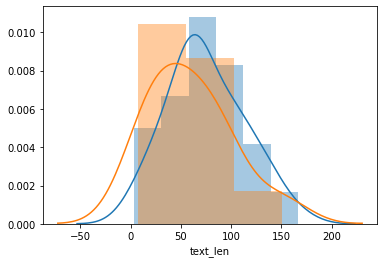

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df_pred[(df_pred['label']==1)&(df_pred['pred']==1)]['text_len'])
sns.distplot(df_pred[(df_pred['label']==1)&(df_pred['pred']==0)]['text_len'])
plt.show()

In [0]:
er = df_pred[(df_pred['label']==1)&(df_pred['pred']==0)].head(100).reset_index(drop=True)

In [0]:
er['question_tok'] = er['question'].apply(lambda x:tokenizer.tokenize(x))
er['text_tok'] = er['text'].apply(lambda x:tokenizer.tokenize(x))

In [0]:
er.head()

,question,text,label,pred,text_len,question_tok,text_tok
0,Bettoven viết bản sonat ánh trăng để tặng cho ai,Ludwig van Beethoven viết bản sonata này dành ...,1,0,64,"[Bet, ##tov, ##en, viết, bản, sona, ##t, ánh, ...","[Ludwig, van, Beethoven, viết, bản, sona, ##ta..."
1,Biểu tượng của Canada,Cô và Kevin Reynolds là cả hai biểu tượng trượ...,1,0,12,"[Bi, ##ểu, tượng, của, Canada]","[Cô, và, Kevin, Reynolds, là, cả, hai, biểu, t..."
2,"Ấp Hà Đông, tiền thân của làng hoa đầu tiên ở ...",Diện tích đất khai phá ban đầu ở Ấp Hà Đông ch...,1,0,100,"[Ấ, ##p, Hà, Đông, ,, tiền, thân, của, làng, h...","[Di, ##ện, tích, đất, khai, phá, ban, đầu, ở, ..."
3,Thành phố nào là thủ đô của Ba Lan,Vác-sa-va là thủ đô của Ba Lan,1,0,7,"[Thành, phố, nào, là, thủ, đô, của, Ba, Lan]","[V, ##ác, -, sa, -, va, là, thủ, đô, của, Ba, ..."
4,Pháp tấn công xâm lược Việt Nam vào ngày tháng...,"Năm 1958, thực dân Pháp nổ súng tấn công bán đ...",1,0,51,"[Pháp, tấn, công, xâm, lược, Việt, Nam, vào, n...","[Năm, 1958, ,, thực, dân, Pháp, nổ, súng, tấn,..."


In [0]:
for i in range(0,len(er)):
  print('question: %s\nanswer: %s\nprediction:%s\nquestion_tok: %s\ntext_tok: %s\n' % (er.loc[i]['question'],er.loc[i]['text'],er.loc[i]['pred'],er.loc[i]['question_tok'],er.loc[i]['text_tok']))


question: Bettoven viết bản sonat ánh trăng để tặng cho ai
answer: Ludwig van Beethoven viết bản sonata này dành cho cô học sinh dương cầm 17 tuổi của ông Gräfin Giulietta Guicciardi (1784–1856) vào năm 1801 và sau khi ông mất vài năm thì bản sonate được nhà phê bình âm nhạc Ludwig Rellstab đặt cho cái tên phổ biến như bây giờ, ông đã so sánh bản nhạc với ánh trăng trên hồ Lucerne.
prediction:0
question_tok: ['Bet', '##tov', '##en', 'viết', 'bản', 'sona', '##t', 'ánh', 'tr', '##ăng', 'để', 'tặng', 'cho', 'ai']
text_tok: ['Ludwig', 'van', 'Beethoven', 'viết', 'bản', 'sona', '##ta', 'này', 'dành', 'cho', 'cô', 'học', 'sinh', 'dương', 'cầm', '17', 'tuổi', 'của', 'ông', 'Gräfin', 'G', '##iul', '##iet', '##ta', 'G', '##ui', '##ccia', '##rdi', '(', '1784', '[UNK]', '1856', ')', 'vào', 'năm', '1801', 'và', 'sau', 'khi', 'ông', 'mất', 'vài', 'năm', 'thì', 'bản', 'sona', '##te', 'được', 'nhà', 'phê', 'bình', 'âm', 'nhạc', 'Ludwig', 'Re', '##lls', '##tab', 'đặt', 'cho', 'cái', 'tên', 'phổ', 'biế

In [0]:
test_dict = download('https://dl.challenge.zalo.ai/ZAC2019_VietnameseWikiQA/test.zip','test')

262144/257843 [==============================] - 1s 2us/step


In [0]:
from pandas.io.json import json_normalize
test = json_normalize(test_dict,'paragraphs',['__id__','question','title'])

In [0]:
test_InputExamples = test.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = 0), axis = 1)

In [0]:
df_test = model_predict(estimator_from_tfhub, test_InputExamples)

In [0]:
len(test)

2678

In [0]:
df_sub = pd.merge(test,df_test,left_index=True,right_index=True)

In [0]:
df_final = df_sub[df_sub['pred']==1][['__id__','id']].reset_index(drop=True)

In [0]:
df_final = df_final.rename(columns={'id':'answer','__id__':'test_id'})

In [0]:
df_final.to_csv('submission_5.csv',index=False)